In [1]:
import torch
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import math
import time
import matplotlib as mpl
%matplotlib inline
from torch import distributions as dist

This document covers the python code of training a singleton network with declarative node formulated as follows
\begin{align}
 	\begin{array}{rll}
\text{minimize}& c_1 x_1- c_2x_2 \\
 \text{subject to} 
 &x_1+x_2 \leq 30 \\
 & x_2 \geq 0,  x_1 \geq 1\\
\end{array}
 \end{align}

Its feasible region is plotted as below.


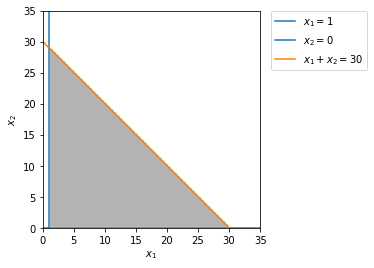

In [2]:
d = np.linspace(-2,70,300)
x,y = np.meshgrid(d,d)
plt.imshow( ((x>=1) & (y>=0) & (x+y<=30)).astype(int) , 
               extent=(x.min(),x.max(),y.min(),y.max()),origin="lower", cmap="Greys", alpha = 0.3);


# plot the lines defining the constraints
x = np.linspace(-2, 70, 2000)
y1 = (x*0) + 0
y3 = 30 - x

plt.axvline(x=1, label = r'$x_1 = 1$')
plt.plot(x, 0*np.ones_like(y1), label = r'$x_2 = 0$')
plt.plot(x, y3, label=r'$x_1 + x_2 = 30$')
plt.xlim(0,35)
plt.ylim(0,35)
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
# plt.title('Feasibile region of sample optimisation problem')
plt.show()

LP always has its solution locate on one of feasible region vertices. We initialise the parameter $c$ at (-4,-8), so that the associated optimal solution is at (30,0). We train this network aiming to let it update $c$ to achieve an optimal solution x at (1,29).

In [3]:
class perturbations():

    def __init__(self,func,num_samples,sigma,noise,batched):
        self.func = func
        self.num_samples = num_samples
        self.sigma = sigma
        self.noise = noise
        self.batched = batched
        
    def sample_noise_with_gradients(noise,shape):
        _GUMBEL = 'gumbel'
        _NORMAL = 'normal'
        SUPPORTED_NOISES = (_GUMBEL, _NORMAL)
        if noise not in SUPPORTED_NOISES:
            raise ValueError('{} noise is not supported. Use one of [{}]'.format(
            noise, SUPPORTED_NOISES))
        if noise == _GUMBEL:
            sampler = dist.gumbel.Gumbel(0.0, 1.0)
            samples = sampler.sample(shape)
            gradients = 1 - torch.exp(-samples)
        elif noise == _NORMAL:
            sampler = dist.normal.Normal(0.0, 1.0)
            samples = sampler.sample(shape)
            gradients = samples
        return samples, gradients

    def forward(self,input_tensor):
        original_input_shape = input_tensor.size()
        if self.batched:
            if original_input_shape[0] < 2:
                raise ValueError('Batched inputs must have at least rank two')
        else:  # Adds dummy batch dimension internally.
            input_tensor = torch.unsqueeze(input_tensor,0)
        input_shape = torch.tensor(input_tensor.size(),dtype=torch.int)  # [B, D1, ... Dk], k >= 1, Dimension of the tensor, in a sigle number.
        #input_shape = input_tensor.size()
        perturbed_input_shape = torch.cat((torch.tensor([self.num_samples]), input_shape)) #The storage space size for all perturbed sequence.

        noises = perturbations.sample_noise_with_gradients(self.noise, perturbed_input_shape) #Create noises
        additive_noise, noise_gradient = tuple([noise for noise in noises]) #Cast the noise to make the noise and input tensor operable
        perturbed_input = torch.unsqueeze(input_tensor, 0) + self.sigma * additive_noise #Add noises to the input tensor, if the expansion in dimension necessary tho?

        # [N, B, D1, ..., Dk] -> [NB, D1, ..., Dk].
        flat_batch_dim_shape = torch.cat((torch.tensor([-1]), input_shape[1:]))
        perturbed_input = torch.reshape(perturbed_input, tuple(flat_batch_dim_shape))
        # Calls user-defined function in a perturbation agnostic manner.
        perturbed_output = self.func(perturbed_input)
        # [NB, D1, ..., Dk] ->  [N, B, D1, ..., Dk].
        perturbed_input = torch.reshape(perturbed_input, tuple(perturbed_input_shape))
        # Either
        #   (Default case): [NB, D1, ..., Dk] ->  [N, B, D1, ..., Dk]
        # or
        #   (Full-reduce case) [NB] -> [N, B]
        perturbed_output_shape = torch.cat(
        (torch.tensor([self.num_samples]), torch.tensor([-1]), torch.tensor(perturbed_output.size()[1:])))
        perturbed_output = torch.reshape(perturbed_output, tuple(perturbed_output_shape))
        forward_output = torch.mean(perturbed_output,0)

        if not self.batched:
            forward_output = forward_output[0]
        self.original_input_shape = original_input_shape
        self.perturbed_input = perturbed_input
        self.noise_gradient = noise_gradient
        self.perturbed_output = perturbed_output
        return forward_output

    def backward(self,grad_output):
        if len(self.perturbed_input.size()) > len(self.perturbed_output.size()):
            self.grad_output = torch.unsqueeze(self.grad_output,-1)
            self.perturbed_output = torch.unsqueeze(self.perturbed_output,-1)
        if not self.batched:
            grad_output = torch.unsqueeze(grad_output,0)
        flatten = lambda t: torch.reshape(t, (t.size()[0], t.size()[1], -1))
        grad_output = torch.reshape(grad_output,(grad_output.size()[0],-1))
        self.perturbed_output = flatten(self.perturbed_output)
        noise_grad = flatten(self.noise_gradient)
        g = torch.einsum('nbd,nb->bd', self.noise_gradient,
                      torch.einsum('nbd,bd->nb', self.perturbed_output, grad_output))
        g = torch.mean(g,0)
        g /= self.sigma
        return g

In [4]:
def Sample_LinProg(x):
#     x = x.clone().detach().numpy()
    solution = torch.zeros_like(x)
    for i in range(x.shape[0]):
        u = cp.Variable(2)
        coe = x[i].clone().detach().numpy()
        objec = lambda coe,u: cp.Minimize(coe@u)
        constraints = [u[0] >= 1,u[0]+u[1] <= 30, u>=0]
        prob = cp.Problem(objec(coe,u),constraints)
        prob.solve()
        solution[i] = torch.tensor(u.value)
    return solution

perturbed_Sample_Linprog = perturbations(Sample_LinProg,2000,1,'gumbel',False)

[ 1.44463384 28.27323146]


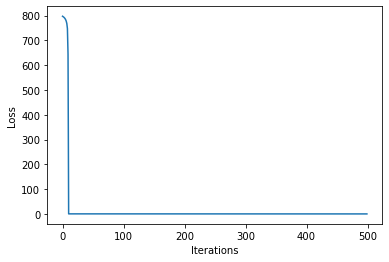

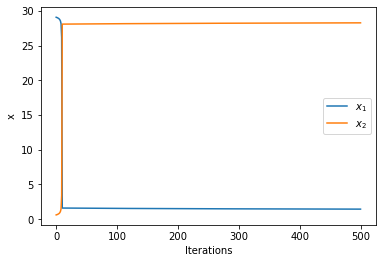

In [5]:
n=2
def loss_grad(x_bar,x=torch.tensor([1.,29.])):
    return (x_bar - x)
def BF_gradient(t,u):
    dyy = np.ones((n,n))*(30-np.sum(u))**(-2) + np.diag((u+ np.array([-1,0]))**(-2))
    dxy = np.eye(n)*t
    return -np.linalg.inv(dyy)@dxy
                          
x = np.array([1.,29.])
c = np.array([-8.,-4.])
t = 0.4
max_iter = 500
loss_trac = []
solution_trac = np.zeros((max_iter,2))
for i in range(max_iter):
    u = cp.Variable(2)
    objec = cp.Minimize(t*c@u-cp.log(u[0]-1)-cp.log(30.-u[1]-u[0])-cp.log(u[1]))
    prob = cp.Problem(objec)
    prob.solve()
    loss = 0.5*np.linalg.norm(u.value-x,2)**2
    loss_trac.append(loss)
    solution_trac[i] = u.value
    loss_gradient = loss_grad(u.value,x)
    if np.linalg.norm(loss_gradient,2) < 1e-4:
           break
    c = c - 0.01*loss_gradient @ BF_gradient(t,u.value)
print(u.value)
plt.figure(1)
plt.plot(loss_trac)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.figure(2)
plt.plot(solution_trac[:,0],label = '$x_1$')
plt.plot(solution_trac[:,1],label = '$x_2$')
plt.xlabel('Iterations')
plt.ylabel('x')
plt.legend()

[ 1.44463384 28.27323146]
0.3629458848639945


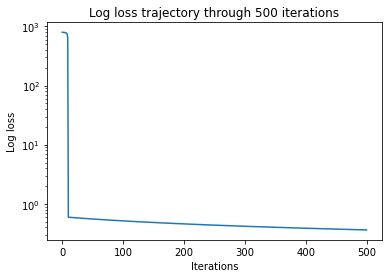

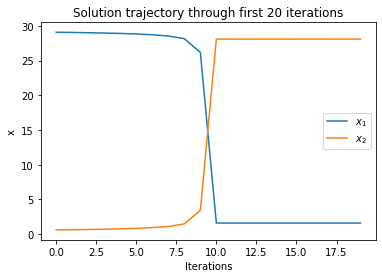

In [6]:
plt.figure(1)
plt.plot(loss_trac)
plt.xlabel('Iterations')
plt.ylabel('Log loss')
plt.yscale('log')
plt.title('Log loss trajectory through 500 iterations')
plt.figure(2)
plt.plot(solution_trac[:20,0],label = '$x_1$')
plt.plot(solution_trac[:20,1],label = '$x_2$')
plt.xlabel('Iterations')
plt.ylabel('x')
plt.title('Solution trajectory through first 20 iterations')
plt.legend()
print(solution_trac[-1])
print(loss_trac[-1])

tensor([ 2.5225, 27.4775])
tensor(2.3180)


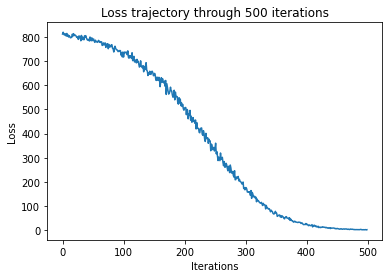

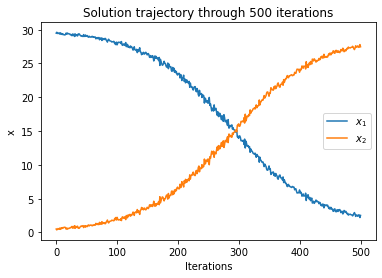

In [7]:
def loss_grad(x_bar,x=torch.tensor([1.,29.])):
    return (x_bar - x)

x = torch.tensor([1.,29.])
c = torch.tensor([-8.,-4.])
max_iter = 500
loss_trac = []
solution_trac = []
for i in range(max_iter):
    solution = perturbed_Sample_Linprog.forward(c)
    loss = 0.5*torch.linalg.norm(solution-x,2)**2
    loss_gradient = loss_grad(solution)
    solution_grad = perturbed_Sample_Linprog.backward(loss_gradient)
    loss_trac.append(loss)
    solution_trac.append(solution)

    if np.linalg.norm(loss_gradient,2) < 1e-4:
           break
    c = c - 0.01*(solution_grad/torch.linalg.norm(solution_grad,2))
solution_trac = torch.stack(solution_trac,dim=0)
plt.figure(1)
plt.plot(loss_trac)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss trajectory through 500 iterations')
plt.figure(2)
plt.plot(solution_trac[:,0],label = '$x_1$')
plt.plot(solution_trac[:,1],label = '$x_2$')
plt.xlabel('Iterations')
plt.ylabel('x')
plt.title('Solution trajectory through 500 iterations')
plt.legend()
print(solution_trac[-1])
print(loss_trac[-1])

tensor(0.)
tensor([ 1., 29.])


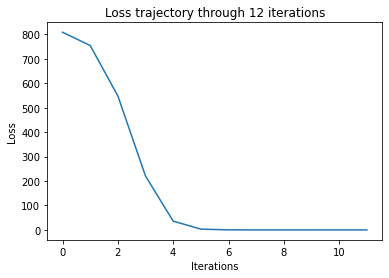

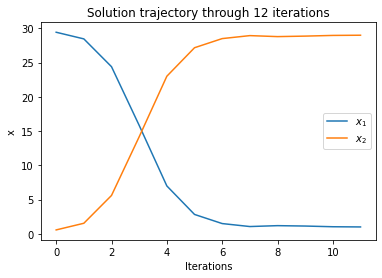

In [13]:
def loss_grad(x_bar,x=torch.tensor([1.,29.])):
    return (x_bar - x)

x = torch.tensor([1.,29.])
c = torch.tensor([-8.,-4.])
max_iter = 500
loss_trac = []
solution_trac = []
for i in range(max_iter):
    solution = perturbed_Sample_Linprog.forward(c)
    loss = 0.5*torch.linalg.norm(solution-x,2)**2
    loss_gradient = loss_grad(solution)
    solution_grad = perturbed_Sample_Linprog.backward(loss_gradient)
    loss_trac.append(loss)
    solution_trac.append(solution)

    if np.linalg.norm(loss_gradient,2) < 1e-4:
           break
    c = c -  (solution_grad/torch.linalg.norm(solution_grad,2))
solution_trac = torch.stack(solution_trac,dim=0)
plt.figure(1)
plt.plot(loss_trac)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss trajectory through {} iterations'.format(len(solution_trac)))
plt.figure(2)
plt.plot(solution_trac[:,0],label = '$x_1$')
plt.plot(solution_trac[:,1],label = '$x_2$')
plt.xlabel('Iterations')
plt.ylabel('x')
plt.title('Solution trajectory through {} iterations'.format(len(solution_trac)))
plt.legend()
print(loss_trac[-1])
print(solution_trac[-1])